In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/ML AI Project/AllFiles/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd 

In [3]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from scipy.stats import kurtosis



In [4]:
from scipy.io import loadmat

# List of patient id's that correspond to file names 

NoPainFiles = ['1004103_20070104_2Hz.mat','1008101_20061006_2Hz.mat','1026101_20070831_2Hz.mat',
            '1031101_20071102_2Hz.mat','2002101_20060708_2Hz.mat','2009101_20061028_2Hz.mat',
            '2017101_20061202_2Hz.mat','2023101_20070106_2Hz.mat','2026101_20070210_2Hz.mat',
            '2039102_20070811_2Hz.mat','2051101_20071201_2Hz.mat','2065101_20080927_2Hz.mat',
            '2111101_20100320_2Hz.mat','3008101_20070109_2Hz.mat','3021101_20070412_2Hz.mat',
            '3050101_20080114_2Hz.mat','3058101_20080314_2Hz.mat','3063101_20080629_2Hz.mat',
            '3071101_20090123_2Hz.mat','3073101_20090220_2Hz.mat']

PainFiles = ['1006101_20060915_2Hz.mat','1009101_20061013_2Hz.mat','1013101_20061201_2Hz.mat',
             '1019101_20070608_2Hz.mat','2003101_20060729_2Hz.mat','2006101_20060916_2Hz.mat',
             '2007101_20061014_2Hz.mat','2036101_20070616_2Hz.mat','2047101_20070922_2Hz.mat',
             '2055101_20080405_2Hz.mat','2057101_20080712_2Hz.mat','2066101_20081011_2Hz.mat',
             '2068101_20081129_2Hz.mat','2103101_20100123_2Hz.mat','2105101_20100116_2Hz.mat',
             '3007101_20070108_2Hz.mat','3026101_20070515_2Hz.mat','3029101_20080411_2Hz.mat',
             '3065101_20080727_2Hz.mat','3069101_20090118_2Hz.mat']

#Additive list of all files 

AllFiles = [*NoPainFiles, *PainFiles]

In [5]:
def timeDiff(mat,time1,time2): 
    # function returns difference in two times (24hr clock) in 1/2 seconds 
    # str of var name (sleep_end and sleep_onset for example gives duration of sleep)
    # input is list entry, eg: ['05-Jan-2007 06:46:04']
    # for sleep start time to seconds 
    # time2 is later time

    startTime = mat[time1][0]
    startTime = startTime.split()[1]
    startTime = startTime.split(':')
    startTimeSecs = int(startTime[0])*3600 + int(startTime[1])*60 + int(startTime[2])
    # for sleep end time to seconds 
    endTime = mat[time2][0]
    endTime = endTime.split()[1]
    endTime = endTime.split(':')
    endTimeSecs = int(endTime[0])*3600 + int(endTime[1])*60 + int(endTime[2])

    Duration = endTimeSecs - startTimeSecs
    if Duration < 0:
        return (Duration + (24*3600))*2
    else:
        return Duration*2



def processedSignals(mat, signal): 
    # function to process RRI, PPGa, timerel
    # input a string that corresponds to variable name for dataset 
    # Could be 'timerel', 'RRI', or 'PPGa'

    rawSig = mat[signal]
    startTime = timeDiff(mat,'starttime','sleep_onset') #in 1/2 seconds, i.e index
    endTime = timeDiff(mat,'starttime','sleep_end') #in 1/2 seconds, i.e index
    processedSig = rawSig[startTime:endTime]

    return processedSig

def createDataFrames(mat):
    # processing time, making it start at 0 
    time = processedSignals(mat,'timerel')
    t = np.arange(0, 0.5*np.shape(time)[0], 0.5, dtype='float64')
    t = np.reshape(t,(np.shape(time)[0],1))

    # loading RRI/PPGa
    RRI = processedSignals(mat,'RRI')
    PPGa = processedSignals(mat,'PPGa')

    # dataframe of RRI and PPGa over time
    df = pd.DataFrame(np.hstack((t, RRI, PPGa)), columns = ['timerel', 'RRI', 'PPGa'])
    return df

def segment(df):
    # split dataframe into 5 minute signals 
    num_seconds = df.RRI.size / 2 
    num_5mins = int(num_seconds//300)
    split_data = np.array_split(df, num_5mins)
    # returned as a list
    return split_data

In [6]:
RRI = [] # initializing empty list to store data
PPGa = []
labels = []

#looping over all files
for i in range(len(AllFiles)):
    mat = loadmat(data_dir + AllFiles[i])
    DF = createDataFrames(mat)
    split_data = segment(DF)    
    for j in range(len(split_data)):
        if AllFiles[i] in PainFiles:
#             labels.append([PainFiles[i%20][:-8], 1])
            labels.append([1.])
        elif AllFiles[i] in NoPainFiles:
#             labels.append([PainFiles[i%20][:-8], 0])   
            labels.append([0.]) 
        sample_RRI = np.copy(split_data[j].RRI.to_numpy())
        sample_PPGa = np.copy(split_data[j].PPGa.to_numpy())

        RRI.append(sample_RRI[:600])
        PPGa.append(sample_PPGa[:600])
        
labels = torch.tensor(labels).float()

In [7]:
RRI = np.array(RRI)
PPGa = np.array(PPGa)

In [8]:
labels.shape

torch.Size([3910, 1])

In [9]:
def mean(data,no_elements):
    X=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]-no_elements+1):        
        X[:,i]=np.mean(data[:,i:i+no_elements],axis=1)
    return X

def variance(data,no_elements):
    X=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]-no_elements+1):
        X[:,i]=np.var(data[:,i:i+no_elements],axis=1)
    return X

def kurt(data, no_elements):
    X=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]-no_elements+1):
        X[:,i]=kurtosis(data[:,i:i+no_elements],axis=1)
    return X

def median(data,no_elements):
    X=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]-no_elements+1):
        X[:,i]=np.median(data[:,i:i+no_elements],axis=1)
    return X

def maximum(data,no_elements):
    X=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]-no_elements+1):        
        X[:,i]=np.amax(data[:,i:i+no_elements],axis=1)
    return X

def minimum(data,no_elements):
    X=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]-no_elements+1):        
        X[:,i]=np.amin(data[:,i:i+no_elements],axis=1)
    return X

def sig_image(data,size1,size2):
    X=np.zeros((data.shape[0],size1,size2))
    for i in range(data.shape[0]):
        X[i]=(data[i].reshape(size1,size2))
    return X

In [10]:
col_mean = np.nanmean(RRI, axis=0)
col_mean.shape

(600,)

In [11]:
np.array(RRI)[:,1].shape

(3910,)

In [12]:
# fill NA values with column mean

for col in range(np.shape(RRI)[1]):
    RRI[:,col] = np.nan_to_num(RRI[:,col], nan = col_mean[col])

    
col_mean = np.nanmean(PPGa, axis=0)

for col in range(np.shape(PPGa)[1]):
    PPGa[:,col] = np.nan_to_num(PPGa[:,col], nan = col_mean[col])

In [13]:
# channel_mean=(mean(x,10)).astype(np.float16)
# x_m=sig_image(channel_mean,40)
# channel_median=(median(x,10)).astype(np.float16)
# x_md=sig_image(x,40)
sc = StandardScaler()



channel_mean=sc.fit_transform(mean(RRI,8))
channel_median=sc.fit_transform(median(RRI,8))
channel_var = sc.fit_transform(variance(RRI,8))
channel_max = sc.fit_transform(maximum(RRI,8))
channel_min = sc.fit_transform(minimum(RRI,8))
x_m_RRI = sig_image(channel_mean,25,24)
x_med_RRI = sig_image(channel_median,25,24)
x_var_RRI = sig_image(channel_var, 25,24)
x_max_RRI = sig_image(channel_max,25,24)
x_min_RRI = sig_image(channel_min,25,24)
x_amplitude_RRI = sig_image((channel_max - channel_min),25,24)

channel_mean=sc.fit_transform(mean(PPGa,8))
channel_median=sc.fit_transform(median(PPGa,8))
channel_var = sc.fit_transform(variance(PPGa,8))
channel_max = sc.fit_transform(maximum(PPGa,8))
channel_min = sc.fit_transform(minimum(PPGa,8))
channel_kurtosis = sc.fit_transform(kurt(PPGa,8))
x_m_PPGa = sig_image(channel_mean,25,24)
x_med_PPGa = sig_image(channel_median,25,24)
x_var_PPGa = sig_image(channel_var, 25,24)
x_max_PPGa = sig_image(channel_max,25,24)
x_min_PPGa = sig_image(channel_min,25,24)
x_amplitude_PPGa = sig_image((channel_max - channel_min),25,24)
x_kurtosis_PPGa = sig_image(channel_kurtosis,25,24)

In [14]:
x_RRI = sig_image(sc.fit_transform(RRI),25,24)
x_PPGa = sig_image(sc.fit_transform(PPGa),25,24)

In [15]:
print(x_RRI.shape)
print(x_PPGa.shape)

(3910, 25, 24)
(3910, 25, 24)


In [16]:
np.count_nonzero(np.isnan(x_med_PPGa)[:,:,0])

0

In [17]:
np.count_nonzero(np.isnan(x_PPGa)[:,0][:,4])

0

In [18]:
# X=np.stack((x_RRI, x_PPGa, x_m_RRI, x_med_RRI, x_var_RRI, x_max_RRI, x_min_RRI, x_amplitude_RRI,
#             x_med_PPGa, x_var_PPGa, x_max_PPGa, x_min_PPGa, x_amplitude_PPGa),axis=1)
X=np.stack((x_RRI, x_PPGa, x_m_RRI, x_max_RRI, x_amplitude_RRI, x_kurtosis_PPGa, x_amplitude_PPGa),axis=1)

In [19]:
# shape = X.shape
# X_reshaped = X.reshape(shape[0], -1)
# X_reshaped = X_reshaped[~np.any(np.isnan(X_reshaped), axis=1)]
# X = X_reshaped.reshape(X_reshaped.shape[0], *shape[1:])

In [20]:
X.shape

(3910, 7, 25, 24)

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(20)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [22]:
# sig_train = torch.from_numpy(trainx)
# sig_test = torch.from_numpy(testx)
# lab_train= torch.from_numpy(trainlabel)
# lab_test = torch.from_numpy(testlabel)

In [23]:
# import torch.utils.data as data_utils
# batch_size = 128 
# train_tensor = data_utils.TensorDataset(sig_train, lab_train) 
# train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True,num_workers=2)

In [24]:
# # batch_size = 1024
# test_tensor = data_utils.TensorDataset(sig_test, lab_test) 
# test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

In [25]:
# sig_train.size()

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(7, 48, kernel_size=3,stride=1,padding = 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(48, 48, kernel_size=5, stride=1, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(48,64, kernel_size=4,stride =1)
        self.mp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dp1 = nn.Dropout(0.5)
        self.relu4 = nn.ReLU()
        self.fc1= nn.Linear(1024, 600)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(600,1)

        # self.sig = nn.Sigmoid()
    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.mp1(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.mp2(x)
        x = self.relu4(x)
        x = self.dp1(x)
        x = x.view(in_size,-1)
        x = self.fc1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        # x = self.sig(x)
        return x # F.log_softmax(x, dim=1)

In [27]:
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"


In [28]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(7, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (conv4): Conv2d(48, 64, kernel_size=(4, 4), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.5, inplace=False)
  (relu4): ReLU()
  (fc1): Linear(in_features=1024, out_features=600, bias=True)
  (dp2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=600, out_features=1, bias=True)
)

In [29]:
from torchsummary import summary

print(summary(model, X.shape[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 25, 24]           3,072
              ReLU-2           [-1, 48, 25, 24]               0
            Conv2d-3           [-1, 48, 25, 24]          20,784
              ReLU-4           [-1, 48, 25, 24]               0
            Conv2d-5           [-1, 48, 23, 22]          57,648
         MaxPool2d-6           [-1, 48, 11, 11]               0
              ReLU-7           [-1, 48, 11, 11]               0
            Conv2d-8             [-1, 64, 8, 8]          49,216
         MaxPool2d-9             [-1, 64, 4, 4]               0
             ReLU-10             [-1, 64, 4, 4]               0
          Dropout-11             [-1, 64, 4, 4]               0
           Linear-12                  [-1, 600]         615,000
          Dropout-13                  [-1, 600]               0
           Linear-14                   

In [30]:
num_epochs = 90
batch_size = 68 
criterion = nn.BCEWithLogitsLoss()

In [31]:
# count = 0
# total_step = len(train_loader)
# loss_list = []
# train_acc_list = []
# test_acc_list = []

# current_best_accuracy = 0.0

# for epoch in range(num_epochs):
#     model.train()
#     for i, (signals, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
        
#         # Run the forward pass
#         signals=signals.to(device)
#         labels=labels.float().to(device)
#         outputs = model(signals.float())
#         loss = criterion(outputs, labels)
#         loss_list.append(loss.item())

#         # Backprop and perform Adam optimisation
        
#         loss.backward()
#         optimizer.step()
#         # Track the accuracy
#         total = len(labels)
#         predicted = torch.where(torch.sigmoid(outputs.data) >= 0.5, 1., 0.)
# #         print(predicted)
# #         print(labels)
#         correct = (predicted == labels.long()).sum().item()
#         train_accuracy = 100 * (correct / float(total))
#         train_acc_list.append(train_accuracy)


#         # count += 1
#         if count % 50 == 0:
#             model.eval()
#             # Calculate Accuracy         
#             correct = 0
#             total = 0
#             # Iterate through test dataset
#             for signals, labels in test_loader:
#                 signals=signals.to(device)
#                 labels=labels.float().to(device)
#                 # Forward propagation
#                 outputs = model(signals.float())
                
#                 # Get predictions from the maximum value
#                 predicted = torch.where(torch.sigmoid(outputs.data) >= 0.5, 1., 0.)
                
#                 # Total number of labels
#                 total += len(labels)
                
#                 correct += (predicted == labels).sum().item()
            
#             test_accuracy = 100 * correct / float(total)
            
#             # store loss and iteration
#             loss_list.append(loss.item())
#             test_acc_list.append(test_accuracy)
            
#         if (epoch+1) % 5 == 0 or epoch==0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
#                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
#                           train_accuracy, test_accuracy))
#     if np.mean(test_acc_list[-total_step:]) > current_best_accuracy:
#         print("Current epoch is the best so far. Saving model...") 
#         torch.save(model.state_dict(),'current_best_model')
#         current_best_accuracy = np.mean(test_acc_list[-total_step:])

In [32]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for signals, labels in dataloader:
        optimizer.zero_grad()
        
        # Run the forward pass
        signals=signals.to(device)
        labels=labels.float().to(device)
        outputs = model(signals.float())
        loss = loss_fn(outputs, labels)
        train_loss += loss.item() * signals.size(0)

        # Backprop and perform Adam optimisation
        
        loss.backward()
        optimizer.step()
        # Track the accuracy
        # total = len(labels)
        predicted = torch.where(torch.sigmoid(outputs.data) >= 0.5, 1., 0.)
#         print(predicted)
#         print(labels)
        train_correct += (predicted == labels).sum().item()
        # train_accuracy = 100 * (correct / float(total))
        # train_acc_list.append(train_accuracy)
    return train_loss, train_correct

def val_epoch(model, device, dataloader, loss_fn):
    val_loss, val_correct = 0.0, 0
    model.eval()
    # Iterate through validation dataset
    for signals, labels in dataloader:
        signals=signals.to(device)
        labels=labels.float().to(device)
        # Forward propagation
        outputs = model(signals.float())
        loss = loss_fn(outputs, labels)
        val_loss+=loss.item() * signals.size(0)
        # Get predictions from the maximum value
        predicted = torch.where(torch.sigmoid(outputs.data) >= 0.5, 1., 0.)
                
        # Total number of labels
        # total += len(labels)
                
        val_correct += (predicted == labels).sum().item()
            
        # test_accuracy = 100 * correct / float(total)
            
    return val_loss, val_correct


In [33]:
# from sklearn.model_selection import train_test_split
# trainx, testx, trainlabel, testlabel = train_test_split(X, np.array(labels), test_size=0.25, random_state=20)

k=5
splits=KFold(n_splits=k, shuffle=True, random_state=20)

fold_acc={}


In [34]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

torch_x = torch.from_numpy(X)


dataset = TensorDataset(torch_x, labels)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    
    model = CNN()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=val_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
    # Saving the model
    save_path = f'./model-fold-{fold+1}.pth'
    torch.save(model.state_dict(), data_dir+save_path)   

Fold 1
Epoch:1/90 AVG Training Loss:0.647 AVG Test Loss:0.596 AVG Training Acc 63.17 % AVG Test Acc 70.59 %
Epoch:2/90 AVG Training Loss:0.596 AVG Test Loss:0.568 AVG Training Acc 69.92 % AVG Test Acc 72.12 %
Epoch:3/90 AVG Training Loss:0.570 AVG Test Loss:0.568 AVG Training Acc 72.47 % AVG Test Acc 74.04 %
Epoch:4/90 AVG Training Loss:0.559 AVG Test Loss:0.537 AVG Training Acc 73.40 % AVG Test Acc 74.17 %
Epoch:5/90 AVG Training Loss:0.545 AVG Test Loss:0.521 AVG Training Acc 73.72 % AVG Test Acc 74.04 %
Epoch:6/90 AVG Training Loss:0.534 AVG Test Loss:0.512 AVG Training Acc 73.72 % AVG Test Acc 74.55 %
Epoch:7/90 AVG Training Loss:0.518 AVG Test Loss:0.501 AVG Training Acc 74.30 % AVG Test Acc 75.45 %
Epoch:8/90 AVG Training Loss:0.510 AVG Test Loss:0.501 AVG Training Acc 75.00 % AVG Test Acc 75.19 %
Epoch:9/90 AVG Training Loss:0.498 AVG Test Loss:0.509 AVG Training Acc 75.77 % AVG Test Acc 74.17 %
Epoch:10/90 AVG Training Loss:0.491 AVG Test Loss:0.494 AVG Training Acc 75.26 % AVG

In [35]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))  

Performance of 5 fold cross validation
Average Training Loss: 0.2277 	 Average Test Loss: 0.5260 	 Average Training Acc: 89.737 	 Average Test Acc: 81.522


In [36]:
# create a new model with the same input-output dimension as before
bestmodel = CNN()

# load the "state_dict" from file into the new model
bestmodel.load_state_dict(torch.load(data_dir+'./model-fold-5.pth'))
bestmodel.to(device)

CNN(
  (conv1): Conv2d(7, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (conv4): Conv2d(48, 64, kernel_size=(4, 4), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.5, inplace=False)
  (relu4): ReLU()
  (fc1): Linear(in_features=1024, out_features=600, bias=True)
  (dp2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=600, out_features=1, bias=True)
)

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
score = []
correct = 0
threshold = 0.6
# iterate over test data
bestmodel.eval()
for signals, labels in test_loader:
        signals=signals.to(device)
        labels=labels.float().to(device)        
        # Forward propagation
        outputs = torch.sigmoid(bestmodel(signals.float())).cpu()
                
        # Get predictions from the maximum value
        predicted = torch.where(outputs.data >= threshold, 1., 0.).numpy()

        score.extend(outputs.data.numpy()) # Save output score
        
        y_pred.extend(predicted) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        
        y_true.extend(labels) # Save Truth
        
        correct += (predicted == labels).sum().item()

# constant for classes
classes = ('No Pain', 'Pain')

# Build confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)

In [47]:
accuracy = correct/len(test_loader.sampler) * 100
print(np.round(accuracy,2), "%")

86.45 %


In [48]:
cm = confusion_matrix(y_true, y_pred)

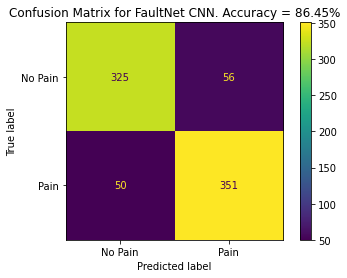

In [55]:
ConfusionMatrixDisplay(cm, display_labels = ('No Pain', 'Pain')).plot()
plt.title(f'Confusion Matrix for FaultNet CNN. Accuracy = {np.round(accuracy,2)}%')
plt.savefig(data_dir+"CNN_confusion_matrix.png")
plt.show()

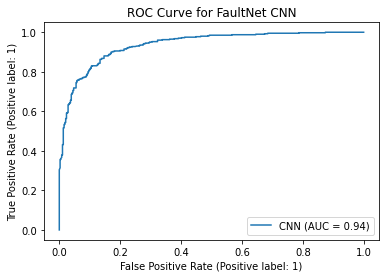

In [56]:
RocCurveDisplay.from_predictions(y_true, score, name='CNN')
plt.title('ROC Curve for FaultNet CNN')
plt.savefig(data_dir+"CNN_ROC.png")

plt.show()